In [15]:
# FEM Mesh Generation
import numpy as np
import matplotlib.pyplot as plt
#number of loaded elements 
#(has to be less than number of element column wise) or radius
nf=6
w=1 #weights
n=4 #number of nodes per element
# col=31 #number of column of nodes
# row=31 #number of row of nodes
# a=1
# b=1
col=10*nf+1 #number of column of nodes
row=10*nf+1 #number of row of nodes
a=(10*nf)/(2*(row-1)) #half element width
b=(10*nf)/(2*(col-1)) #half element height
tot_el=(col-1)*(row-1) #total number of element
E=10**5 #psf
E_grad=5000 #psf/ft
mu=0.35
p=400 #applied pressure
theta=2*np.pi
rg=np.array([1/np.sqrt(3),-1/np.sqrt(3),-1/np.sqrt(3),1/np.sqrt(3)])
sg=np.array([1/np.sqrt(3),1/np.sqrt(3),-1/np.sqrt(3),-1/np.sqrt(3)])
#Constructing global X-Y coordinates
xglobal=np.array([0.0]*(row**2))
yglobal=np.array([0.0]*(col**2))
#Mesh generator
#Assigning x-cordinate and y-ccordinate to the nodes
for i in range(1,row+1):
    for j in range(1,col+1):
        node=(j-1)*row+i
        xglobal[node-1]=(j-1)*2*a
        yglobal[node-1]=(i-1)*2*b
yglobal=-yglobal #convert to right hand coordinate system

#Connectivity Matrix (relating local to global (nodes) coordinate)
connect=np.array([0]*(tot_el*4)).reshape(tot_el,4)
el_num=0
for i in range(1,col):
    for j in range(1,row):
        el_num+=1
        connect[el_num-1,0]=i*row+j
        connect[el_num-1,1]=(i-1)*row+j
        connect[el_num-1,2]=(i-1)*row+j+1
        connect[el_num-1,3]=i*row+j+1

In [16]:
#C-matrix
def cmat(ylocal,r,s,mu):
    c_cons=np.array([0.0]*(4*4)).reshape(4,4)
    c_cons[0,0],c_cons[0,1],c_cons[0,3]=1,mu/(1-mu),mu/(1-mu)
    c_cons[1,0],c_cons[1,1],c_cons[1,3]=mu/(1-mu),1,mu/(1-mu)
    c_cons[2,2]=(1-2*mu)/(2*(1-mu))
    c_cons[3,0],c_cons[3,1],c_cons[3,3]=mu/(1-mu),mu/(1-mu),1
    const=(1-mu)/((1+mu)*(1-2*mu))
    def f_i(r,s):
        h=[0.25*(1+r)*(1+s),0.25*(1-r)*(1+s),0.25*(1-r)*(1-s),0.25*(1+r)*(1-s)]
        return h
    mod=E-(E_grad*(np.matmul((np.array(f_i(r,s)).reshape(1,len(f_i(r,s)))),
                                               (ylocal.reshape(len(ylocal),1)))))
    c_cons=mod*const*c_cons
    return c_cons


In [17]:
#Construct B-matrix
def bmat(r,s,n,a,b,xlocal):
    #interpolating function    
    h=[0.25*(1+r)*(1+s),0.25*(1-r)*(1+s),0.25*(1-r)*(1-s),0.25*(1+r)*(1-s)]
    #initialize empty B array
    B_diff=np.array([0.0]*(n*2*4)).reshape(4,n*2)
    #define derivative in r,s
    dhr=[0.25*(1+s),-0.25*(1+s),-0.25*(1-s),0.25*(1-s)]
    dhs=[0.25*(1+r),0.25*(1-r),-0.25*(1-r),-0.25*(1+r)]
    #define derivative in x,y
    dhx=[(1/a)*dhr[0],(1/a)*dhr[1],(1/a)*dhr[2],(1/a)*dhr[3]]
    dhy=[(1/b)*dhs[0],(1/b)*dhs[1],(1/b)*dhs[2],(1/b)*dhs[3]]
    #B-matrix component
    for i in range(1,5):
        B_diff[0,2*i-2]=dhx[i-1]
        B_diff[1,2*i-1]=dhy[i-1]
        B_diff[2,2*i-2]=dhy[i-1]
        B_diff[2,2*i-1]=dhx[i-1]
        B_diff[3,2*i-2]=h[i-1]/(np.matmul((np.array(h).reshape(1,len(h))),
                                          (xlocal.reshape(len(xlocal),1))))
    return B_diff

In [18]:
#assemble element matrix
ke=np.array([0.0]*(n**3)).reshape(2*n,2*n)
for k in range(tot_el):
    for r in range(len(rg)):
        for s in range(len(sg)):
            for i in range(1,5):
                xlocal=np.array([0]*(4))
                ylocal=np.array([0]*(4))
                node=connect[k,i-1]
                xlocal[i-1]=xglobal[node-1]
                ylocal[i-1]=yglobal[node-1]
            r_1=rg[r]
            s_1=sg[s]
            h=[0.25*(1+r_1)*(1+s_1),0.25*(1-r_1)*(1+s_1),0.25*(1-r_1)*(1-s_1),0.25*(1+r_1)
               *(1-s_1)]
            h=np.array((h)).reshape(1,4)
            x_gauss=np.matmul(h,xlocal.reshape(4,1))
            t=x_gauss*theta
            ke=ke+(np.matmul((np.matmul(np.transpose(bmat(rg[r],sg[s],n,a,b,xlocal)),
                                       cmat(ylocal,rg[r],sg[s],mu))),
                            bmat(rg[r],sg[s],n,a,b,xlocal))*a*b*w*t)

In [19]:
#assemble global stiffness matrix
ndof_elem=8 #number of degree of freedom per element
size_kg=2*col*row #number of element per row and column
#initialize empty global stiffness matrix
kg=np.array([0.0]*(size_kg**2)).reshape(size_kg,size_kg) 
gdof=np.array([0]*(8)) #initialize holder for global dof
for elnum in range(tot_el): 
    for i in range(4):
        gdof[2*i]=2*connect[elnum,i]-1
        gdof[2*i+1]=2*connect[elnum,i]
    for j in range(ndof_elem):
        for k in range(ndof_elem):
            kg[gdof[j]-1,gdof[k]-1]=kg[gdof[j]-1,gdof[k]-1]+ke[j,k]

In [20]:
#impose boundary condition and construct load vector
#imposing constraint on the center of system (x-dir)
for node in range(col):
    dof=2*node
    kg[dof,:], kg[:,dof]=0,0
    kg[dof,dof]=1
#imposing constraint on far-field boundary (right)
for node in range((row-1)*col,row*col):
    #X-DOF
    dof_x=2*node
    kg[dof_x,:]=0
    kg[:,dof_x]=0
    kg[dof_x,dof_x]=1
    #Y_DOF
    dof_y=2*node+1
    kg[dof_y,:]=0
    kg[:,dof_y]=0
    kg[dof_y,dof_y]=1
for node in range(col-1,col*row,col):
    dof=2*node+1
    kg[dof,:]=0
    kg[:,dof]=0
    kg[dof,dof]=1  

#constructing load vector (Need fixing)
load_vec=np.array([0.0]*(size_kg)).reshape(size_kg,1) #initialize empty load vector
counter=1
for elnum in range(0,(nf-1)*(row-1)+1,(row-1)):
    ry_1=(4/3)*p*theta*a**2+(1/2)*a*p*theta*((2*counter-1)*a-a)
    ry_2=(2/3)*p*theta*a**2+(1/2)*a*p*theta*((2*counter-1)*a-a)
    nodeg_one=connect[elnum,0]
    dofg_one=2*nodeg_one-1
    load_vec[dofg_one]=load_vec[dofg_one]+ry_1
    nodeg_two=connect[elnum,1]
    dofg_two=2*nodeg_two-1
    load_vec[dofg_two]=load_vec[dofg_two]+ry_2
    counter+=1

In [21]:
nodal_u=np.linalg.solve(kg,-load_vec) #assign negative direction for load vector

In [22]:
#post-processing
nodal_ux=nodal_u[::2] #extract nodal displacement in horizontal dir
nodal_uy=nodal_u[1::2] #extract nodal displacement in vertical dir
loc_x=np.array([0.0]*(n)) #initialize empty vector for local x-disp.
loc_y=np.array([0.0]*(n)) #initialize empty vector for local y-disp.
disp=np.array([0.0]*(2*n)) #initialize empty vector for local combined disp.
stress=np.array([0.0]*(4*tot_el)).reshape(4,tot_el) #initialize empty vector for stress tensor
for elnum in range(tot_el):
    for i in range(4):
        loc_x[i]=nodal_ux[connect[elnum,i]-1] #relating global DOF to local DOF
        loc_y[i]=nodal_uy[connect[elnum,i]-1] #relating global DOF to local DOF
        for k in range(len(loc_x)):
            disp[2*k]=loc_x[k] #assemble complete disp. matrix
            disp[2*k+1]=loc_y[k]
        el_strain=np.matmul(bmat(0,0,n,a,b,loc_x),disp).reshape(np.int(len(disp)/2),1) #calculate element strain
        stress[:,elnum]=np.matmul(cmat(loc_y,0,0,mu),el_strain).reshape(4,) #calculate element stress

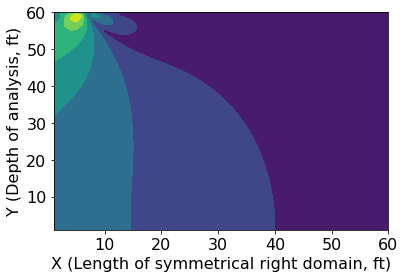

In [23]:
#plotting meshgrid
mean_stress=(stress[0,:]+stress[1,:]+stress[2,:])/3
mean_stress=mean_stress.reshape(tot_el,1)
C=(stress[0,:]+stress[1,:])*0.5
c_1=abs((stress[0,:]-stress[1,:])*0.5)
c_2=(stress[2,:])**2
R=np.sqrt(c_1+c_2)
sigma_1=C+R
sigma_2=stress[1,:]
sigma_3=C-R
a=1
oc=(1/3)*np.sqrt((sigma_1-sigma_2)**2+(sigma_2-sigma_3)**2 + (sigma_3-sigma_1)**2)
pore_p=oc*a
pore_p=pore_p.reshape(tot_el,1)
x=np.arange(1,row,1)
y=np.flip(np.arange(1,col,1))
X, Y=np.meshgrid(x,y)
Z=np.transpose(pore_p.reshape(row-1,col-1))
# Z=np.transpose(mean_stress.reshape(row-1,col-1))
# Z=np.transpose(stress[1,:].reshape(row-1,col-1))
CS = plt.contourf(X, Y, Z, alpha= 1)
nm, lbl = CS.legend_elements()
# lbl[0]='$0.09$'
# lbl[1]='$0.075$'
# lbl[2]='$0.06$'
# lbl[3]='$0.045$'
# lbl[4]='$0.03$'
# lbl[5]='$0.015$'
# lbl[6]='$0$'
# # lbl[7]='$57613.168$'
# # lbl[8]='$57613.165$'
# lbl=lbl[::-1]
# plt.legend(nm,lbl,title= 'Stress Field (psf)', 
#            fontsize= 8,fancybox=True,bbox_to_anchor=(1.31, 1))
# plt.legend(nm[::-1],lbl[::-1],title= 'Stress Field (psf)', 
#            fontsize= 8,fancybox=True,bbox_to_anchor=(1.43, 1))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('X (Length of symmetrical right domain, ft)',fontsize=16)
plt.ylabel('Y (Depth of analysis, ft)',fontsize=16)
plt.savefig('1.png', bbox_inches='tight', dpi=600)
plt.show()

In [27]:
np.array([x for y in zip(loc_x, loc_y) for x in y])

array([ 0.00000000e+00,  0.00000000e+00,  1.70495867e-09, -3.62589881e-08,
        1.34204055e-08,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [28]:
surface_disp=np.array([0.0]*(col))
for i in range(col):
    surface_disp[i]=nodal_uy[col*i]

ValueError: x and y must have same first dimension, but have shapes (121,) and (11,)

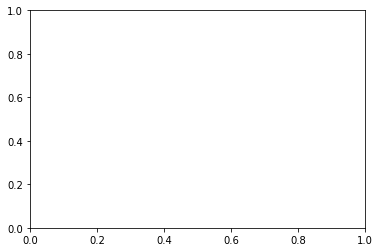

In [29]:
x=np.arange(1,122,1)
plt.plot(x,surface_disp)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('X (Length of symmetrical right domain, ft)',fontsize=16)
plt.ylabel('Displacement (ft)',fontsize=16)
plt.savefig('disp.png', bbox_inches='tight', dpi=600)

In [30]:
Z.shape

(10, 10)

In [24]:
import pandas
z=pandas.DataFrame(Z)
z.to_csv('z.csv')